In [1]:
pip install tensorflow

In [2]:
pip install plotly

# LSTM -  Predicția de preț pentru Bitcoin vs. prețul actual utilizând cele mai recente date pentru testare și date de antrenare mai vechi

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv("BTC-USD.csv")

# Preprocess the data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display the first rows of the dataset
print(df.head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-04-16  6640.454102  7134.450684  6555.504395  7116.804199  7116.804199   
2020-04-17  7116.552734  7167.183105  7050.332031  7096.184570  7096.184570   
2020-04-18  7092.291504  7269.956543  7089.247070  7257.665039  7257.665039   
2020-04-19  7260.922363  7280.521973  7167.054688  7189.424805  7189.424805   
2020-04-20  7186.873535  7240.290527  6835.502930  6881.958496  6881.958496   

                 Volume  
Date                     
2020-04-16  46783242377  
2020-04-17  32513423567  
2020-04-18  32447188386  
2020-04-19  31311210215  
2020-04-20  37747113936  


In [4]:
# Drop rows with missing values
df.dropna(inplace=True)

# Normalize the dataset
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])
scaled_df = pd.DataFrame(scaled_df, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], index=df.index)

# Define the size of the training set (80% training, 20% testing)
train_size = int(len(scaled_df) * 0.8)

# Split the dataset into training and testing sets
train_data = scaled_df.iloc[:train_size]
test_data = scaled_df.iloc[train_size:]

In [5]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [6]:
# Define sequence length
seq_length = 20

# Create sequences for training data
X_train, y_train = create_sequences(train_data.values, seq_length)

# Create sequences for testing data
X_test, y_test = create_sequences(test_data.values, seq_length)

In [7]:
# Define a simpler model to prevent overfitting
model = Sequential([
    LSTM(units=64, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    LSTM(units=32, activation="relu", return_sequences=True),
    Dropout(0.4),
    LSTM(units=16),
    Dropout(0.4),
    Dense(units=6)
])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

# Train the model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
epochs = 100  # Change this value to set the number of epochs
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping])
# history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            18176     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 6)                 1

In [9]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

9/9 [==============================] - 0s 9ms/step - loss: 0.0010
Test Loss: 0.0010371353710070252


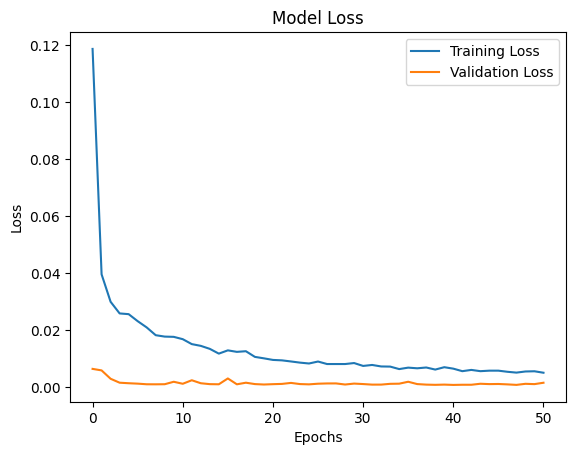

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Extract only the 'Close' prices for evaluation
original_ytrain = scaler.inverse_transform(y_train)[:, 3]
original_ytest = scaler.inverse_transform(y_test)[:, 3]
train_predict_close = train_predict[:, 3]
test_predict_close = test_predict[:, 3]

9/9 [==============================] - 0s 9ms/step


In [12]:
import plotly.graph_objects as go

# Plot predicted vs actual 'Close' prices with Plotly for interactivity
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test_data.index[seq_length:],
    y=original_ytest,
    mode='lines+markers',
    name='Actual',
    line=dict(color='blue'),
    marker=dict(size=5)
))

fig.add_trace(go.Scatter(
    x=test_data.index[seq_length:],
    y=test_predict_close,
    mode='lines',
    name='Predicted',
    line=dict(color='red'),
    marker=dict(size=5)
))

fig.update_layout(
    title='Actual vs Predicted Close Price',
    xaxis_title='Date',
    yaxis_title='Close Price',
    legend_title='Legend',
    hovermode='x unified'
)

fig.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate
import math

# print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict_close)))
# print("Train data MAE: ", mean_absolute_error(original_ytrain, train_predict_close))
# print("-------------------------------------------------------------------------------------")
# print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest, test_predict_close)))
# print("Test data MAE: ", mean_absolute_error(original_ytest, test_predict_close))

# Evaluation metrics RMSE and MAE
train_rmse = math.sqrt(mean_squared_error(original_ytrain, train_predict_close))
train_mae = mean_absolute_error(original_ytrain, train_predict_close)
test_rmse = math.sqrt(mean_squared_error(original_ytest, test_predict_close))
test_mae = mean_absolute_error(original_ytest, test_predict_close)

# Calculate MAPE
mape_train = np.mean(np.abs((original_ytrain - train_predict_close) / original_ytrain)) * 100
mape_test = np.mean(np.abs((original_ytest - test_predict_close) / original_ytest)) * 100

# print("-------------------------------------------------------------------------------------")
# print("Train data MAPE: ", mape_train)
# print("Test data MAPE: ", mape_test)

# Calculate Directional Accuracy (DA)
train_direction = np.sign(np.diff(original_ytrain))
train_predict_direction = np.sign(np.diff(train_predict_close))
train_direction_accuracy = np.mean(train_direction == train_predict_direction) * 100

test_direction = np.sign(np.diff(original_ytest))
test_predict_direction = np.sign(np.diff(test_predict_close))
test_direction_accuracy = np.mean(test_direction == test_predict_direction) * 100
# print("-------------------------------------------------------------------------------------")
# print("Train data Directional Accuracy: ", train_direction_accuracy)
# print("Test data Directional Accuracy: ", test_direction_accuracy)

# Create a DataFrame to display the metrics

metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE', 'Directional Accuracy'],
    'Train Data': [train_rmse, train_mae, mape_train, train_direction_accuracy],
    'Test Data': [test_rmse, test_mae, mape_test, test_direction_accuracy]
})

# Display the DataFrame with more spaces between columns
print("\n", metrics_df.to_string(index=False, col_space=15))


               Metric      Train Data       Test Data
                RMSE     2701.114471     1498.779582
                 MAE     2120.866286     1051.820658
                MAPE        8.562874        3.009359
Directional Accuracy       51.548270       49.806950


# LSTM - Predicția de preț pentru Bitcoin vs. prețul actual utilizând cele mai recente date pentru antrenare și date de testare mai vechi

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-04-16  6640.454102  7134.450684  6555.504395  7116.804199  7116.804199   
2020-04-17  7116.552734  7167.183105  7050.332031  7096.184570  7096.184570   
2020-04-18  7092.291504  7269.956543  7089.247070  7257.665039  7257.665039   
2020-04-19  7260.922363  7280.521973  7167.054688  7189.424805  7189.424805   
2020-04-20  7186.873535  7240.290527  6835.502930  6881.958496  6881.958496   

                 Volume  
Date                     
2020-04-16  46783242377  
2020-04-17  32513423567  
2020-04-18  32447188386  
2020-04-19  31311210215  
2020-04-20  37747113936  
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 64)            18176     
                                            

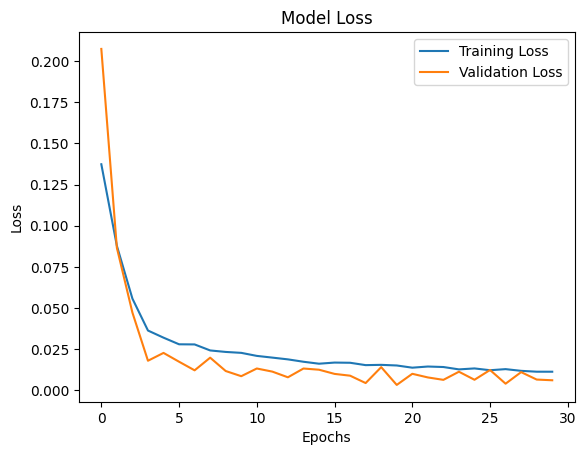

35/35 [==============================] - 0s 13ms/step



               Metric      Train Data       Test Data
                RMSE     2461.659858     4424.469513
                 MAE     1769.544441     3464.625268
                MAPE        4.970005       16.292858
Directional Accuracy       51.737452       48.360656


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv("BTC-USD.csv")

# Preprocess the data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display the first rows of the dataset
print(df.head())


# Drop rows with missing values
df.dropna(inplace=True)

# Normalize the dataset
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])
scaled_df = pd.DataFrame(scaled_df, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], index=df.index)

# Define the size of the training set (80% training, 20% testing)
train_size = int(len(scaled_df) * 0.8)

# Split the dataset into training and testing sets
train_data = scaled_df.iloc[train_size:]
test_data = scaled_df.iloc[:train_size]


def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)



# Define sequence length
seq_length = 20

# Create sequences for training data
X_train, y_train = create_sequences(train_data.values, seq_length)

# Create sequences for testing data
X_test, y_test = create_sequences(test_data.values, seq_length)


# Define a simpler model to prevent overfitting
model = Sequential([
    LSTM(units=64, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    LSTM(units=32, activation="relu", return_sequences=True),
    Dropout(0.4),
    LSTM(units=16),
    Dropout(0.4),
    Dense(units=6)
])


from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

# Train the model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
epochs = 100  # Change this value to set the number of epochs
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping])



# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Extract only the 'Close' prices for evaluation
original_ytrain = scaler.inverse_transform(y_train)[:, 3]
original_ytest = scaler.inverse_transform(y_test)[:, 3]
train_predict_close = train_predict[:, 3]
test_predict_close = test_predict[:, 3]



import plotly.graph_objects as go

# Plot predicted vs actual 'Close' prices with Plotly for interactivity
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test_data.index[seq_length:],
    y=original_ytest,
    mode='lines+markers',
    name='Actual',
    line=dict(color='blue'),
    marker=dict(size=5)
))

fig.add_trace(go.Scatter(
    x=test_data.index[seq_length:],
    y=test_predict_close,
    mode='lines',
    name='Predicted',
    line=dict(color='red'),
    marker=dict(size=5)
))

fig.update_layout(
    title='Actual vs Predicted Close Price',
    xaxis_title='Date',
    yaxis_title='Close Price',
    legend_title='Legend',
    hovermode='x unified'
)

fig.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate
import math

# print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict_close)))
# print("Train data MAE: ", mean_absolute_error(original_ytrain, train_predict_close))
# print("-------------------------------------------------------------------------------------")
# print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest, test_predict_close)))
# print("Test data MAE: ", mean_absolute_error(original_ytest, test_predict_close))

# Evaluation metrics RMSE and MAE
train_rmse = math.sqrt(mean_squared_error(original_ytrain, train_predict_close))
train_mae = mean_absolute_error(original_ytrain, train_predict_close)
test_rmse = math.sqrt(mean_squared_error(original_ytest, test_predict_close))
test_mae = mean_absolute_error(original_ytest, test_predict_close)

# Calculate MAPE
mape_train = np.mean(np.abs((original_ytrain - train_predict_close) / original_ytrain)) * 100
mape_test = np.mean(np.abs((original_ytest - test_predict_close) / original_ytest)) * 100

# print("-------------------------------------------------------------------------------------")
# print("Train data MAPE: ", mape_train)
# print("Test data MAPE: ", mape_test)

# Calculate Directional Accuracy (DA)
train_direction = np.sign(np.diff(original_ytrain))
train_predict_direction = np.sign(np.diff(train_predict_close))
train_direction_accuracy = np.mean(train_direction == train_predict_direction) * 100

test_direction = np.sign(np.diff(original_ytest))
test_predict_direction = np.sign(np.diff(test_predict_close))
test_direction_accuracy = np.mean(test_direction == test_predict_direction) * 100
# print("-------------------------------------------------------------------------------------")
# print("Train data Directional Accuracy: ", train_direction_accuracy)
# print("Test data Directional Accuracy: ", test_direction_accuracy)

# Create a DataFrame to display the metrics

metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE', 'Directional Accuracy'],
    'Train Data': [train_rmse, train_mae, mape_train, train_direction_accuracy],
    'Test Data': [test_rmse, test_mae, mape_test, test_direction_accuracy]
})

# Display the DataFrame with more spaces between columns
print("\n", metrics_df.to_string(index=False, col_space=15))